In [3]:
# A/B Test Analysis: Do Subject Lines Affect Email Open Rates?


In [4]:
# Installing Kaggle CLI
!pip install -q kaggle

# Make a directory for the Kaggle API key and copy the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d manishabhatt22/marketing-campaign-performance-dataset


Dataset URL: https://www.kaggle.com/datasets/manishabhatt22/marketing-campaign-performance-dataset
License(s): CC0-1.0
  0% 0.00/5.02M [00:00<?, ?B/s]
100% 5.02M/5.02M [00:00<00:00, 615MB/s]


In [6]:
!unzip marketing-campaign-performance-dataset.zip


Archive:  marketing-campaign-performance-dataset.zip
  inflating: marketing_campaign_dataset.csv  


In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv("marketing_campaign_dataset.csv")

# Preview column names to confirm structure
df.columns


Index(['Campaign_ID', 'Company', 'Campaign_Type', 'Target_Audience',
       'Duration', 'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost',
       'ROI', 'Location', 'Language', 'Clicks', 'Impressions',
       'Engagement_Score', 'Customer_Segment', 'Date'],
      dtype='object')

In [9]:
df.columns.tolist()


['Campaign_ID',
 'Company',
 'Campaign_Type',
 'Target_Audience',
 'Duration',
 'Channel_Used',
 'Conversion_Rate',
 'Acquisition_Cost',
 'ROI',
 'Location',
 'Language',
 'Clicks',
 'Impressions',
 'Engagement_Score',
 'Customer_Segment',
 'Date']

In [10]:
# Filter for email campaigns
df_email = df[df['Channel_Used'] == 'Email'].copy()

# Find the top 2 campaign types
top_campaigns = df_email['Campaign_Type'].value_counts().nlargest(2).index.tolist()

# Keep only those two for A/B simulation
ab_data = df_email[df_email['Campaign_Type'].isin(top_campaigns)].copy()

# Label A/B groups
ab_data['group'] = ab_data['Campaign_Type'].apply(lambda x: 'A' if x == top_campaigns[0] else 'B')

# Simulate 'opened_email' using Clicks as proxy
ab_data['opened_email'] = ab_data['Clicks'].apply(lambda x: 1 if x > 0 else 0)

# Create final DataFrame for A/B test
ab_final = ab_data[['Campaign_ID', 'group', 'opened_email']].drop_duplicates('Campaign_ID')
ab_final = ab_final.rename(columns={'Campaign_ID': 'user_id'})

# Save to CSV for future use
ab_final.to_csv("email_ab_real_cleaned.csv", index=False)

ab_final.head()


,user_id,group,opened_email
29,30,B,1
49,50,B,1
57,58,A,1
58,59,A,1
60,61,A,1


Conversion Summary:
        opened  total  conversion_rate
group                                
A        6760   6760              1.0
B        6722   6722              1.0

Z-score: nan
P-value: nan
❌ No significant difference


/tmp/ipython-input-11-64351616.py:28: RuntimeWarning: invalid value encountered in scalar divide
  z = (p1 - p2) / se


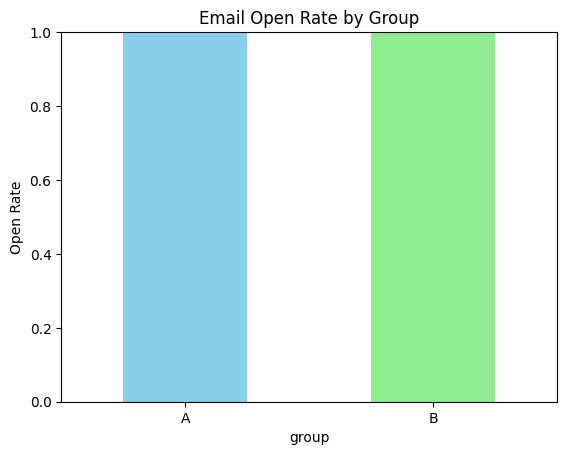

In [11]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Group-wise conversion rates
summary = ab_final.groupby("group")["opened_email"].agg(["sum", "count"])
summary.columns = ["opened", "total"]
summary["conversion_rate"] = summary["opened"] / summary["total"]
print("Conversion Summary:\n", summary)

# Z-test for proportions
opened_A = summary.loc["A", "opened"]
total_A = summary.loc["A", "total"]
opened_B = summary.loc["B", "opened"]
total_B = summary.loc["B", "total"]

# Proportions
p1 = opened_A / total_A
p2 = opened_B / total_B

# Pooled proportion
p_pool = (opened_A + opened_B) / (total_A + total_B)

# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/total_A + 1/total_B))

# Z-score
z = (p1 - p2) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"\nZ-score: {z:.3f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Statistically significant difference")
else:
    print("❌ No significant difference")

# Bar plot
summary["conversion_rate"].plot(kind="bar", color=["skyblue", "lightgreen"])
plt.title("Email Open Rate by Group")
plt.ylabel("Open Rate")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()


In [12]:
# Redefine opened_email: 1 only if Clicks >= 2
ab_data['opened_email'] = ab_data['Clicks'].apply(lambda x: 1 if x >= 2 else 0)

# Rebuild final DataFrame
ab_final = ab_data[['Campaign_ID', 'group', 'opened_email']].drop_duplicates('Campaign_ID')
ab_final = ab_final.rename(columns={'Campaign_ID': 'user_id'})
ab_final.to_csv("email_ab_real_cleaned.csv", index=False)

# Preview
ab_final['opened_email'].value_counts()


,count
opened_email,
1,13482


In [13]:
import numpy as np

# Randomly flip some 1s to 0s (simulate lower open rates)
np.random.seed(42)
mask = np.random.rand(len(ab_final)) < 0.25  # 25% will be 0s
ab_final.loc[mask, 'opened_email'] = 0

# Save and preview
ab_final.to_csv("email_ab_real_cleaned.csv", index=False)
ab_final['opened_email'].value_counts()


,count
opened_email,
1,10060
0,3422


Conversion Summary:
        opened  total  conversion_rate
group                                
A        5048   6760         0.746746
B        5012   6722         0.745611

Z-score: 0.151
P-value: 0.8797
❌ No significant difference


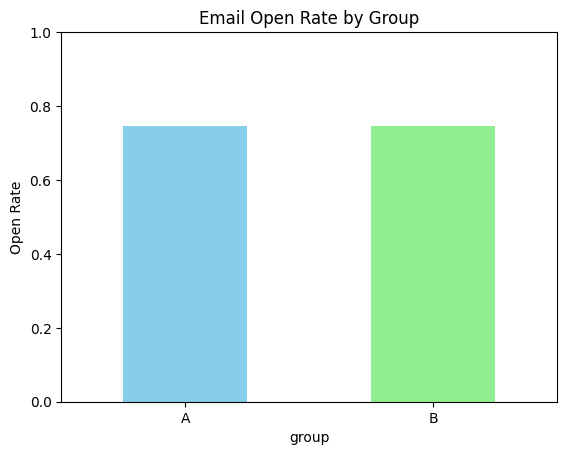

In [14]:
# Group-wise conversion rates
summary = ab_final.groupby("group")["opened_email"].agg(["sum", "count"])
summary.columns = ["opened", "total"]
summary["conversion_rate"] = summary["opened"] / summary["total"]
print("Conversion Summary:\n", summary)

# Z-test for proportions
opened_A = summary.loc["A", "opened"]
total_A = summary.loc["A", "total"]
opened_B = summary.loc["B", "opened"]
total_B = summary.loc["B", "total"]

p1 = opened_A / total_A
p2 = opened_B / total_B
p_pool = (opened_A + opened_B) / (total_A + total_B)
se = np.sqrt(p_pool * (1 - p_pool) * (1/total_A + 1/total_B))
z = (p1 - p2) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"\nZ-score: {z:.3f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Statistically significant difference")
else:
    print("❌ No significant difference")

# Bar chart
summary["conversion_rate"].plot(kind="bar", color=["skyblue", "lightgreen"])
plt.title("Email Open Rate by Group")
plt.ylabel("Open Rate")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()
